* Finally, perform some clustering on the music data

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn import metrics

import umap


In [2]:
# Read in X for unsupervised learning, y to check on performance

X = pd.read_parquet('/home/stu/final_capstone/features_final/X.parq') 

y = pd.read_parquet('/home/stu/final_capstone/features_final/y.parq')["genre"].ravel()   # otherwise get complaints!!!

X.hvplot.table()
print(type(y))
print(y.shape)

<class 'numpy.ndarray'>
(1200,)


In [3]:
# Develop UMAP reduction of dataset for visualization only - suggested by Tiago

umap_results = umap.UMAP(n_neighbors=5,
                         
                         min_dist=0.3,
                         metric='correlation').fit_transform(X)


### Clustering analysis

* Now we turn to unsupervised learning. I tuned models using
    * K-means, with the known value of 6 genres for K
    * Spectral clustering
    * Agglomerative clustering, with a variety of hyperparameters
    * DBSCAN clustering




* Each method was then evaluated via
    * A scatter plot, using a UMAP-based 2-dimensional representation of the clusters
    * Adjusted Rand Index (ARI) - an extrinsic score using the "ground truth" of the known genres
    * Silhouette Score - an intrinsic score with no reference to ground truth

<function matplotlib.pyplot.show(close=None, block=None)>

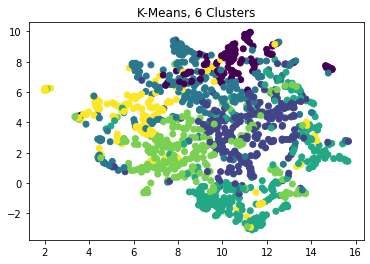

In [4]:
# Try kmeans clustering - visualize and compute scores
# We know that we have 6 genres

kmeans = KMeans(n_clusters=6,random_state=13)
preds = kmeans.fit(X)

plt.figure()
plt.title('K-Means, 6 Clusters')
plt.scatter(umap_results[:,0], umap_results[:,1], c=kmeans.labels_) 
plt.show


In [5]:
labels = kmeans.fit_predict(X)

print("Silhouette:  {}".format(metrics.silhouette_score(X, labels, metric='euclidean')))
print("ARI:         {}".format(metrics.adjusted_rand_score(y, labels)))
      

Silhouette:  0.04588804808922013
ARI:         0.12478291922614493


* Although some clustering is discernable, there is considerable overlap, so k-means does not appear to be a good clustering choice.
    * Could be due to clusters not being "isotropic" (convex), or clusters not having similar variances
* Neither silhouette nor ARI is very good

<function matplotlib.pyplot.show(close=None, block=None)>

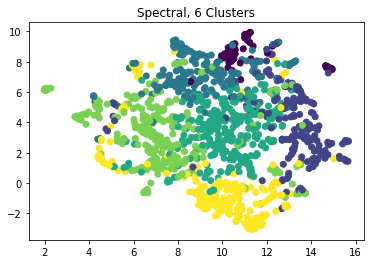

In [6]:
# Try spectral clustering - visualize & scores

spec = SpectralClustering(n_clusters=6,
                          assign_labels="discretize",
                          random_state=13,
                          affinity="nearest_neighbors",
                          n_neighbors=20)
spec.fit(X)

plt.figure()
plt.title('Spectral, 6 Clusters')
plt.scatter(umap_results[:,0], umap_results[:,1], c=spec.labels_) 
plt.show


In [7]:
labels = spec.fit_predict(X)

print("Silhouette:  {}".format(metrics.silhouette_score(X, labels, metric='euclidean')))
print("ARI:         {}".format(metrics.adjusted_rand_score(y, labels)))
      

Silhouette:  0.052816093192751774
ARI:         0.19436906189696773


* Somewhat better scores than for k-means.

* Values still quite low.

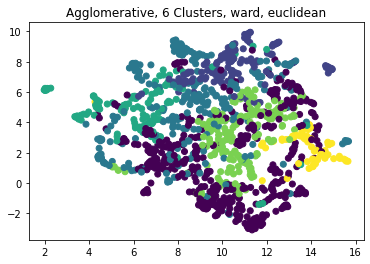

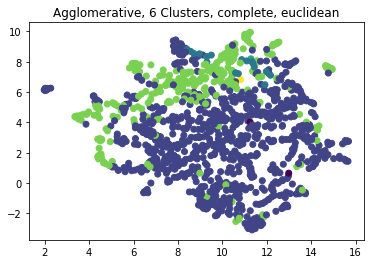

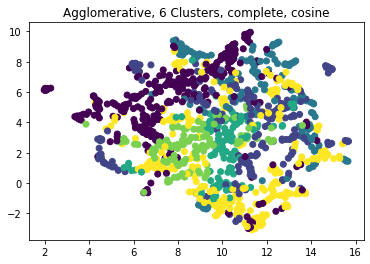

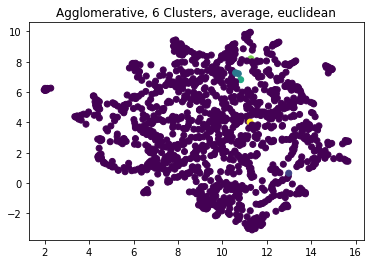

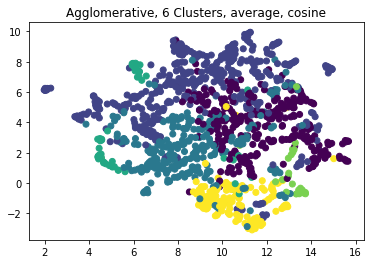

In [8]:
# Try agglomerative clustering with various hyperparameter combos

linkages = ["ward", "complete", "average"]
affinities = ["euclidean", "cosine"]

for linkage in linkages:
    for affinity in affinities:
        if linkage=="ward" and affinity=="cosine":               # sklearn routine doesn't handle this
            continue                                             
        ac = AgglomerativeClustering(n_clusters = 6,             # stop at 6, our known correct number
                                     linkage=linkage,
                                     affinity=affinity
                                    )
        ac.fit(X)

        plt.figure()
        plt.title('Agglomerative, 6 Clusters, '+linkage+', '+affinity)
        plt.scatter(umap_results[:,0], umap_results[:,1], c=ac.labels_)  # Tiago suggested this
        plt.show


* Agglomerative clustering is quite sensitive to hyperparameters chosen.
* Best result here appears to be average linkage with cosine distance, but silhouette score is terrible, ARI not too great either.


In [9]:
ac = AgglomerativeClustering(n_clusters = 6,             
                             linkage='average',
                             affinity='cosine'
                            )
    
labels = ac.fit_predict(X)

print("Silhouette:  {}".format(metrics.silhouette_score(X, labels, metric='euclidean')))
print("ARI:         {}".format(metrics.adjusted_rand_score(y, labels)))


Silhouette:  0.007653372239642275
ARI:         0.14067466294470418


<function matplotlib.pyplot.show(close=None, block=None)>

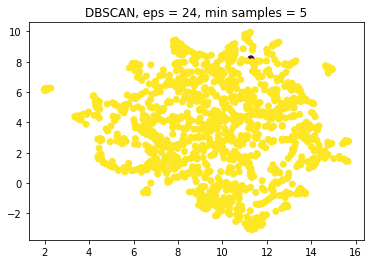

In [10]:
# Try DBSCAN - ditch this if I can't make it perform any better.

eps=24
min_samples = 5

dbscan_cluster = DBSCAN(
                        eps=eps, 
                        min_samples=min_samples
                       )

dbscan_cluster.fit_predict(X)

plt.figure()
plt.title('DBSCAN, eps = '+str(eps)+', min samples = '+str(min_samples))
plt.scatter(umap_results[:,0], umap_results[:,1], c=dbscan_cluster.labels_) 
plt.show


* None of these hyperparameter combinations appear to be very good!
* DBSCAN not worth considering when applied to these features.


### Summary

* Of the approaches examined, spectral clustering appears to perform the best.

* However, performance is not acceptable for a working model; more work needs to be done, likely in the area of feature extraction and selection

